## Step 0: Install Dependencies and Import Libraries

In [1]:
! pip install opencv-python
! pip install matplotlib
! pip install scikit-learn

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Step 1: Vizualize the Data

<Figure size 2000x2000 with 0 Axes>

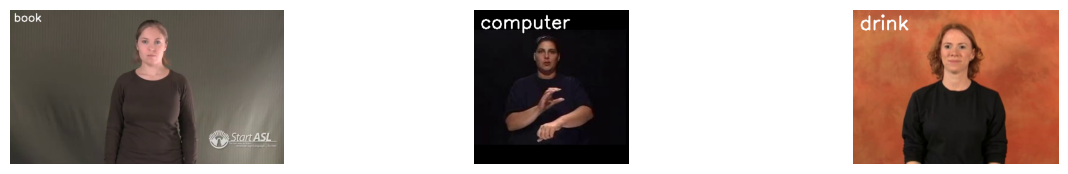

In [3]:
import math
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize = (20, 20))

# Dataset directory name - CHANGE FOR CURRENT DATASET
# dataset_directory_name = 'grouped_videos_2000_mediapipe/grouped_videos_10_1'
dataset_directory_name = 'videos_3'
# dataset_directory_name = 'grouped_videos_2000_original/grouped_videos_10_1'
# dataset_directory_name = 'grouped_videos_10_classes_robust'
# Get the names of the classses
all_class_names = os.listdir(dataset_directory_name)

num_classes = len(all_class_names)
cols = 4
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(20, rows * 2))  # Adjust figure size dynamically based on rows

# Iterate through all labels
for index in range(len(all_class_names)):
    # Retrieve a class name using the index
    selected_class_name = all_class_names[index]

    # Retrieve the list of all video files present in the class directory
    video_file_names_list = os.listdir(f'{dataset_directory_name}/{selected_class_name}')

    # Skip empty classes
    if len(video_file_names_list) == 0:
        continue

    # Select a video file from the class directory
    selected_video_file_name = video_file_names_list[0]

    # Init a VideoCapture object to read from the video file
    video_reader = cv2.VideoCapture(f'{dataset_directory_name}/{selected_class_name}/{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # Releases the VideoCapture object
    video_reader.release()

    # Convert the frame from BGR to RGB format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    # plt.subplot(10, 4, index + 1)
    plt.subplot(rows, cols, index + 1) 
    plt.imshow(rgb_frame)
    plt.axis('off')

In [4]:
import os
import cv2

def display_video_lengths(dataset_directory_name):
    # Get all class names (subfolder names)
    all_class_names = os.listdir(dataset_directory_name)

    # Iterate through each class folder
    for class_name in all_class_names:
        class_path = os.path.join(dataset_directory_name, class_name)
        
        # Skip if it's not a directory
        if not os.path.isdir(class_path):
            continue
        
        # Retrieve the list of all video files in the current class directory
        video_file_names_list = os.listdir(class_path)
        
        # Initialize a list to store the lengths of videos in frames
        video_lengths = []
        
        # Iterate over each video file in the class folder
        for video_file_name in video_file_names_list:
            video_file_path = os.path.join(class_path, video_file_name)
            
            # Initialize VideoCapture to read the video file
            video_reader = cv2.VideoCapture(video_file_path)
            
            # Get the total number of frames in the video
            length = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
            video_lengths.append(length)
            
            # Release the VideoCapture object
            video_reader.release()
        
        # Display the class and lengths of videos
        lengths_str = " ".join(map(str, video_lengths))
        print(f"class: {class_name} | video length's order: {lengths_str} (fr)")

# Run the function to display video lengths
display_video_lengths(dataset_directory_name)


class: book | video length's order: 68 30 86 18 18 28 41 69 90 99 79 93 104 75 82 98 80 93 100 80 87 77 95 75 78 85 88 86 83 63 124 87 64 33 47 96 124 75 100 121 68 68 30 86 18 18 28 38 69 90 99 79 93 104 75 82 98 80 93 100 80 87 77 95 75 78 85 88 86 83 63 124 87 68 64 33 47 96 124 75 100 121 68 68 30 86 18 18 68 68 30 86 18 18 28 38 69 90 99 79 93 104 75 82 98 80 93 100 80 87 77 95 75 78 85 88 86 83 63 124 87 64 33 47 96 124 75 100 121 (fr)
class: computer | video length's order: 52 72 101 81 43 57 43 53 45 40 102 55 53 55 62 73 46 88 102 88 67 77 86 64 78 76 107 36 89 153 52 72 101 81 43 57 43 53 45 40 102 55 53 55 62 73 46 88 102 88 67 77 86 64 78 76 107 36 89 153 (fr)
class: drink | video length's order: 105 70 81 43 91 55 55 57 46 58 48 41 49 49 60 30 59 65 82 58 61 69 61 55 93 89 44 46 37 89 76 133 54 77 122 105 70 81 43 91 55 55 57 46 58 48 40 48 48 59 29 59 65 82 58 61 69 61 55 93 89 44 46 37 89 76 133 54 77 122 (fr)


## Step 2: Preprocess the Dataset

In [5]:
# Specify the height and width to which each video frame will be resized to in our dataset
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128

# Specify the number of frames of a video that will be fed to the model as one sequence
# Videos are 25fps and 1-2 second each
# Each video is 25-50 frames total
# So we will only feed 3030 frames of the original videos to the model 
# SEQUENCE_LENGTH = 15

# Specify the directory containing the dataset
DATASET_DIR = dataset_directory_name

# Specify the list containing the names of the classes used for training
CLASS_LIST = all_class_names

In [6]:
BATCH_SIZE = 30  # As used in DataLoader
LEARNING_RATE = 1e-4  # Optimizer learning rate
WEIGHT_DECAY = 1e-5  # Regularization parameter, if applicable
NUM_EPOCHS = 25  # Total epochs for training

In [7]:
batch_size = BATCH_SIZE
learning_rate = LEARNING_RATE
num_epochs = NUM_EPOCHS

### Step 2.1: Create a function to Extract, Resize, and Normalize Frames

In [8]:
import numpy as np
import cv2

# Define fixed sequence length and frame size for all videos
SEQUENCE_LENGTH = 30  # Adjust this as needed
FRAME_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)  # Adjust frame dimensions as needed (height, width)

def frames_extraction(video_path, sequence_length=SEQUENCE_LENGTH, frame_size=FRAME_SIZE):
    frames_list = []

    # Create a VideoCapture object to read the video file
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the number of frames to skip to extract evenly spaced frames
    skip_frame_window = max(int(video_frames_count / sequence_length), 1)

    # Loop to extract frames
    for frame_counter in range(sequence_length):
        # Set the current frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame_window)

        # Read the frame
        success, frame = video_reader.read()

        # If reading the frame failed (e.g., video ends early), add a black (empty) frame
        if not success:
            frame = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.float32)
        else:
            # Resize the frame and normalize
            frame = cv2.resize(frame, frame_size)
            frame = frame / 255.0  # Normalize to [0, 1] range

        # Append frame to the list
        frames_list.append(frame)

    # Release the video capture object
    video_reader.release()

    return frames_list


### Step 2.2: Create a Function for Dataset Creation

In [9]:
def create_dataset(sequence_length=SEQUENCE_LENGTH, frame_size=FRAME_SIZE):
    features = []
    labels = []
    video_file_paths = []

    for class_index, class_name in enumerate(CLASS_LIST):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path, sequence_length, frame_size)

            # Append frames and labels
            features.append(frames)
            labels.append(class_index)
            video_file_paths.append(video_file_path)

    # Convert lists to NumPy arrays
    features = np.array(features)  # Shape: (num_samples, sequence_length, height, width, channels)
    labels = np.array(labels)

    return features, labels, video_file_paths


In [10]:
# Create the dataset
features, labels, video_file_paths = create_dataset()

Extracting Data of Class: book
Extracting Data of Class: computer
Extracting Data of Class: drink


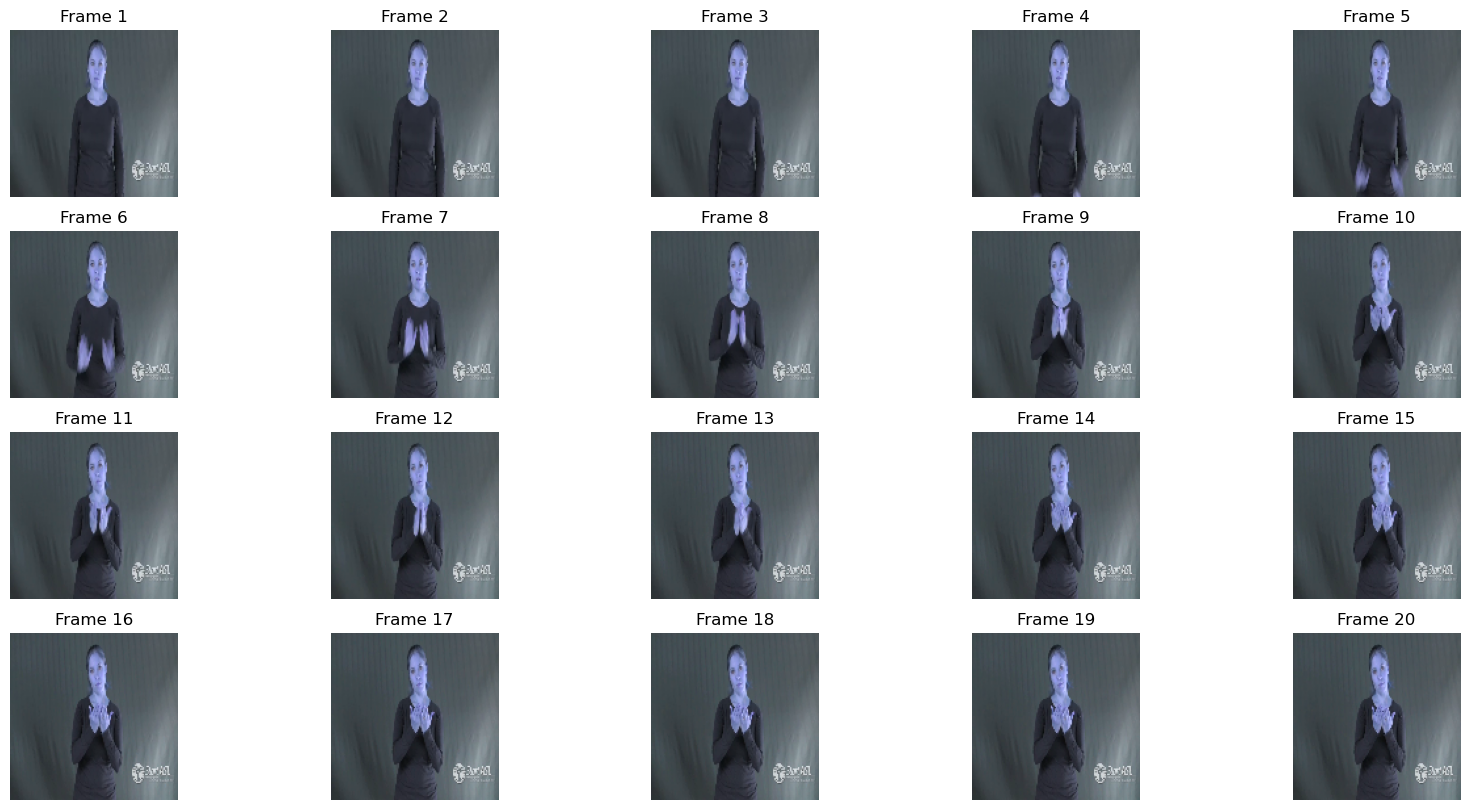

In [11]:
# Visualize a sequence of 15 frames from the first video
plt.figure(figsize=(20, 10))

# Ensure we don't exceed the available frames
sequence_length = min(20, len(features[0]))

for i in range(sequence_length):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns for 20 frames
    plt.imshow(features[0][i])  # First video, ith frame
    plt.title(f'Frame {i + 1}')
    plt.axis('off')

plt.show()

# Step 3b: Split Data into Train and Test (PyTorch)

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into Train (75%) and Test Set (25%)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25, shuffle=True, random_state=27
)

# Verify shapes
print(f"Training Features Shape: {features_train.shape}")
print(f"Testing Features Shape: {features_test.shape}")
print(f"Training Labels Shape: {labels_train.shape}")
print(f"Testing Labels Shape: {labels_test.shape}")


Training Features Shape: (194, 30, 128, 128, 3)
Testing Features Shape: (65, 30, 128, 128, 3)
Training Labels Shape: (194,)
Testing Labels Shape: (65,)


## Step 4b: Implement the 3D CNN Approach using PyTorch

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class ResNet3DCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ResNet3DCNN, self).__init__()
        self.input_channels = input_shape[0]

        # Initial Conv3D layer
        self.conv1 = nn.Conv3d(self.input_channels, 32, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0)

        # Residual Blocks
        self.resblock1 = ResidualBlock3D(32, 32)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0)

        self.resblock2 = ResidualBlock3D(32, 64)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0)

        self.resblock3 = ResidualBlock3D(64, 128)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0)

        self.resblock4 = ResidualBlock3D(128, 256)
        self.pool5 = nn.AdaptiveAvgPool3d((1, 1, 1))  # Global Average Pooling

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Initial Conv3D Layer
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Residual Blocks with Pooling
        x = self.resblock1(x)
        x = self.pool2(x)

        x = self.resblock2(x)
        x = self.pool3(x)

        x = self.resblock3(x)
        x = self.pool4(x)

        x = self.resblock4(x)
        x = self.pool5(x)  # Global Average Pooling

        # Flatten and Fully Connected Layers
        x = torch.flatten(x, start_dim=1)  # Flatten to [batch_size, channels]
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x  # Raw logits, no softmax


In [14]:

# Initialize the PyTorch model
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape = (3, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH)  
num_classes = len(CLASS_LIST)  
model = ResNet3DCNN(input_shape=input_shape, num_classes=num_classes).to(device)

# Test with dummy input
dummy_input = torch.randn(8, 3, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH).to(device)
output = model(dummy_input)
print("Output shape:", output.shape)  # Should match (8, num_classes)


Output shape: torch.Size([8, 3])


In [15]:
# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define input shape and number of classes
input_shape = (3, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH)  # PyTorch expects channels first
num_classes = len(CLASS_LIST)  # Number of classes
print(num_classes)

# Initialize the PyTorch model
model = ResNet3DCNN(input_shape=input_shape, num_classes=num_classes).to(device)

# Summary of the Model
print(model)


3
ResNet3DCNN(
  (conv1): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): ResidualBlock3D(
    (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock2): ResidualBlock3D(
    (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

### Step 4.1: Compile and Train the Model

In [16]:
import os

# Root directory containing class subfolders
root_dir = dataset_directory_name

# Extract class names from the subfolder names
class_names = sorted([d.name for d in os.scandir(root_dir) if d.is_dir()])
print("Class Names:", class_names)


Class Names: ['book', 'computer', 'drink']


In [17]:
# Map integer labels to class names
class_mapping = {i: name for i, name in enumerate(class_names)}
print("Class Mapping:", class_mapping)


Class Mapping: {0: 'book', 1: 'computer', 2: 'drink'}


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, RandomResizedCrop
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm

# Assuming features and labels are numpy arrays or lists
features_train_val, features_test, labels_train_val, labels_test = train_test_split(features, labels, test_size=0.15, random_state=42)
features_train, features_val, labels_train, labels_val = train_test_split(features_train_val, labels_train_val, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
features_train = torch.tensor(features_train, dtype=torch.float32)
features_val = torch.tensor(features_val, dtype=torch.float32)
features_test = torch.tensor(features_test, dtype=torch.float32)

labels_train = torch.tensor(labels_train, dtype=torch.long)  # Assuming integer class labels
labels_val = torch.tensor(labels_val, dtype=torch.long)
labels_test = torch.tensor(labels_test, dtype=torch.long)


# Create TensorDataset
train_dataset = torch.utils.data.TensorDataset(features_train, labels_train)
val_dataset = torch.utils.data.TensorDataset(features_val, labels_val)
test_dataset = torch.utils.data.TensorDataset(features_test, labels_test)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer, Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet3DCNN(input_shape=(3, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH), num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, mode="max", restore_best_weights=True):
        self.patience = patience
        self.mode = mode
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_score, model):
        score = val_score if self.mode == "max" else -val_score
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model_state)

early_stopping = EarlyStopping(patience=20, mode="max", restore_best_weights=True)


c:\Users\Nhan Thai\anaconda3\envs\odessey_asl_env\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training Loop
# num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    with tqdm(train_loader, desc="Training", unit="batch") as train_bar:
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Reshape inputs to match the model's expected shape
            inputs = inputs.permute(0, 4, 1, 2, 3)  # [N, D, H, W, C] -> [N, C, D, H, W]
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Metrics calculation
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            total_train += labels.size(0)  # Total samples in the batch
            correct_train += (predicted == labels).sum().item()  # Correct predictions
            
            # Update progress bar
            train_bar.set_postfix(loss=loss.item())
    
    # Calculate training accuracy
    train_accuracy = 100 * correct_train / total_train  # Train accuracy in percentage
    train_loss /= len(train_loader)  # Average loss per batch

    # Validation phase
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        with tqdm(val_loader, desc="Validation", unit="batch") as val_bar:
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Reshape inputs to match the model's expected shape
                inputs = inputs.permute(0, 4, 1, 2, 3)  # [N, D, H, W, C] -> [N, C, D, H, W]
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Metrics calculation
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)  # Get class predictions
                total_val += labels.size(0)  # Total samples in the batch
                correct_val += (predicted == labels).sum().item()  # Correct predictions
                
                # Update progress bar
                val_bar.set_postfix(loss=loss.item())
    
    # Calculate validation accuracy
    val_accuracy = 100 * correct_val / total_val  # Val accuracy in percentage
    val_loss /= len(val_loader)  # Average loss per batch

    # **Append metrics for plotting**
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Print metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early Stopping
    early_stopping(val_accuracy, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch [1/25]


Validation: 100%|██████████| 2/2 [00:00<00:00,  8.13batch/s, loss=1.08]


Epoch [1/25] - Train Loss: 1.0574, Train Accuracy: 48.86% - Val Loss: 1.0693, Val Accuracy: 59.09%

Epoch [2/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.13batch/s, loss=1.07]


Epoch [2/25] - Train Loss: 0.9988, Train Accuracy: 52.84% - Val Loss: 1.0420, Val Accuracy: 59.09%

Epoch [3/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.22batch/s, loss=1.06] 


Epoch [3/25] - Train Loss: 0.9279, Train Accuracy: 57.95% - Val Loss: 1.0195, Val Accuracy: 59.09%

Epoch [4/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.68batch/s, loss=1.06]


Epoch [4/25] - Train Loss: 0.8294, Train Accuracy: 65.34% - Val Loss: 1.0190, Val Accuracy: 61.36%

Epoch [5/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.18batch/s, loss=1.07]


Epoch [5/25] - Train Loss: 0.7697, Train Accuracy: 76.14% - Val Loss: 1.0361, Val Accuracy: 38.64%

Epoch [6/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.72batch/s, loss=0.901]


Epoch [6/25] - Train Loss: 0.6981, Train Accuracy: 76.14% - Val Loss: 0.8202, Val Accuracy: 65.91%

Epoch [7/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.29batch/s, loss=0.907]


Epoch [7/25] - Train Loss: 0.6140, Train Accuracy: 83.52% - Val Loss: 0.8216, Val Accuracy: 65.91%

Epoch [8/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.25batch/s, loss=0.681]


Epoch [8/25] - Train Loss: 0.5258, Train Accuracy: 88.07% - Val Loss: 0.6286, Val Accuracy: 84.09%

Epoch [9/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.30batch/s, loss=0.632]


Epoch [9/25] - Train Loss: 0.4410, Train Accuracy: 89.77% - Val Loss: 0.5376, Val Accuracy: 86.36%

Epoch [10/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.44batch/s, loss=0.466]


Epoch [10/25] - Train Loss: 0.3530, Train Accuracy: 93.75% - Val Loss: 0.4116, Val Accuracy: 90.91%

Epoch [11/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.34batch/s, loss=0.356]


Epoch [11/25] - Train Loss: 0.3182, Train Accuracy: 92.61% - Val Loss: 0.3388, Val Accuracy: 88.64%

Epoch [12/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.99batch/s, loss=0.746]


Epoch [12/25] - Train Loss: 0.2408, Train Accuracy: 95.45% - Val Loss: 0.5673, Val Accuracy: 84.09%

Epoch [13/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.49batch/s, loss=1.06] 


Epoch [13/25] - Train Loss: 0.2058, Train Accuracy: 94.89% - Val Loss: 0.7862, Val Accuracy: 86.36%

Epoch [14/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.49batch/s, loss=0.314]


Epoch [14/25] - Train Loss: 0.1756, Train Accuracy: 96.59% - Val Loss: 0.2926, Val Accuracy: 88.64%

Epoch [15/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.29batch/s, loss=0.347]


Epoch [15/25] - Train Loss: 0.1392, Train Accuracy: 96.02% - Val Loss: 0.4970, Val Accuracy: 77.27%

Epoch [16/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.81batch/s, loss=0.36]


Epoch [16/25] - Train Loss: 0.0981, Train Accuracy: 98.86% - Val Loss: 0.4558, Val Accuracy: 81.82%

Epoch [17/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.20batch/s, loss=0.548]


Epoch [17/25] - Train Loss: 0.1199, Train Accuracy: 95.45% - Val Loss: 0.5107, Val Accuracy: 75.00%

Epoch [18/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.17batch/s, loss=0.4]  


Epoch [18/25] - Train Loss: 0.0573, Train Accuracy: 98.86% - Val Loss: 0.2812, Val Accuracy: 90.91%

Epoch [19/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.94batch/s, loss=0.512]


Epoch [19/25] - Train Loss: 0.0598, Train Accuracy: 98.86% - Val Loss: 0.3488, Val Accuracy: 90.91%

Epoch [20/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.16batch/s, loss=0.531]


Epoch [20/25] - Train Loss: 0.0364, Train Accuracy: 99.43% - Val Loss: 0.3777, Val Accuracy: 88.64%

Epoch [21/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.17batch/s, loss=0.368]


Epoch [21/25] - Train Loss: 0.0260, Train Accuracy: 99.43% - Val Loss: 0.3260, Val Accuracy: 88.64%

Epoch [22/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.25batch/s, loss=2.57]


Epoch [22/25] - Train Loss: 0.0963, Train Accuracy: 97.73% - Val Loss: 3.1832, Val Accuracy: 27.27%

Epoch [23/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.71batch/s, loss=1.07] 


Epoch [23/25] - Train Loss: 0.0631, Train Accuracy: 98.86% - Val Loss: 0.7220, Val Accuracy: 81.82%

Epoch [24/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.34batch/s, loss=2.2] 


Epoch [24/25] - Train Loss: 0.0371, Train Accuracy: 99.43% - Val Loss: 1.7662, Val Accuracy: 70.45%

Epoch [25/25]


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.17batch/s, loss=1.28] 

Epoch [25/25] - Train Loss: 0.0316, Train Accuracy: 100.00% - Val Loss: 1.0421, Val Accuracy: 84.09%



### Step 4.2: Evaluate the Trained Model

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
model.eval()
test_loss, correct_test, total_test = 0.0, 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 4, 1, 2, 3)  # [N, D, H, W, C] -> [N, C, D, H, W]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Metrics calculation
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.1719, Test Accuracy: 92.31%


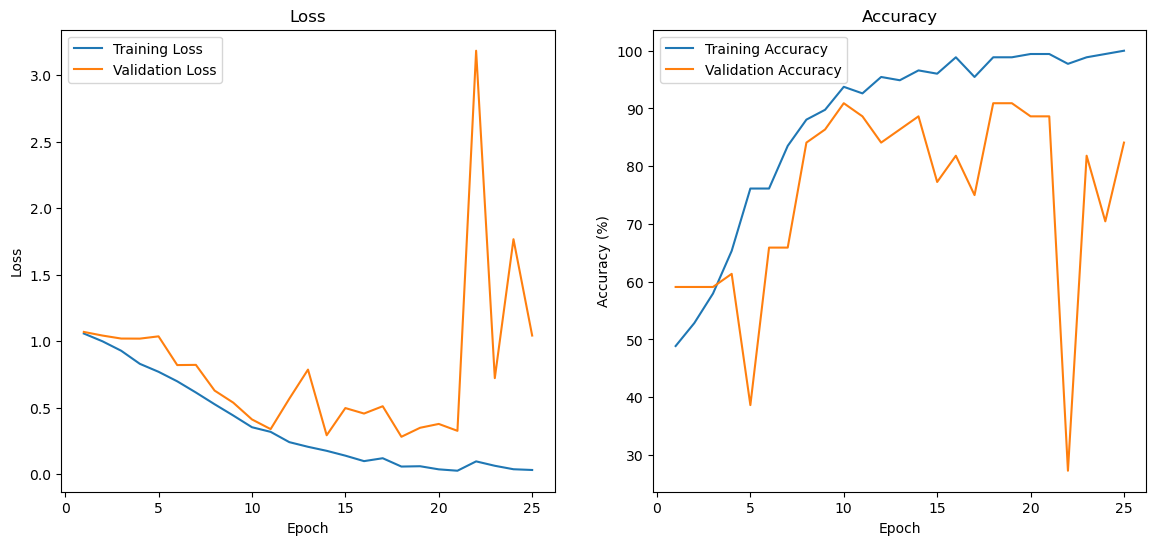

In [21]:
import matplotlib.pyplot as plt

# Plot training vs validation loss and accuracy
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [22]:
unique_labels = sorted(set(all_labels) | set(all_preds))
print("Unique Labels in Data:", unique_labels)
print("Number of Class Names:", len(class_names))
print("Class Names:", class_names)



Unique Labels in Data: [0, 1, 2]
Number of Class Names: 3
Class Names: ['book', 'computer', 'drink']


In [23]:
# Ensure class_names corresponds to the unique labels
class_names = [class_names[label] for label in unique_labels]


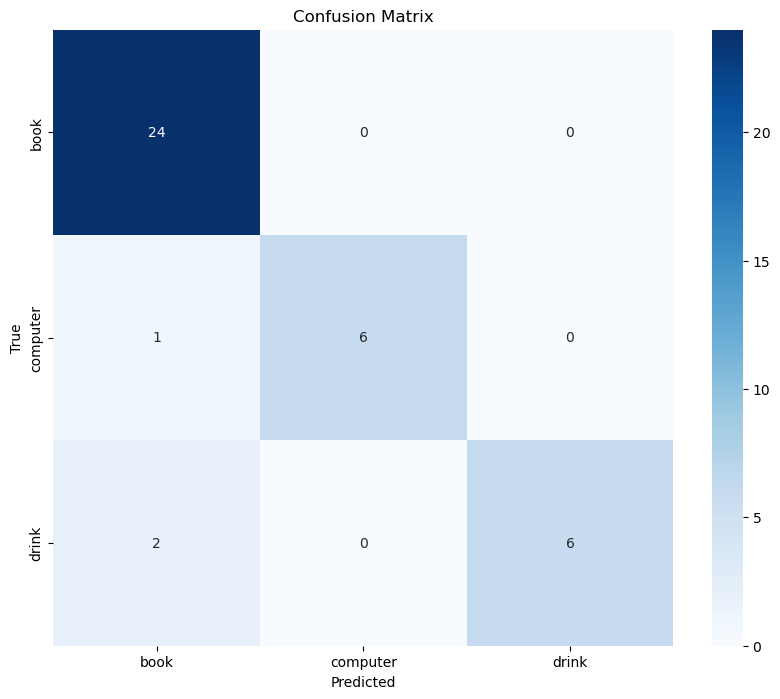

Classification Report:
              precision    recall  f1-score   support

        book       0.89      1.00      0.94        24
    computer       1.00      0.86      0.92         7
       drink       1.00      0.75      0.86         8

    accuracy                           0.92        39
   macro avg       0.96      0.87      0.91        39
weighted avg       0.93      0.92      0.92        39



In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [25]:
# Initialize a list to store true and predicted label pairs
label_pairs = []

model.eval()
with torch.no_grad():
    for sample_idx in range(len(test_dataset)):  # Iterate through all samples
        sample_input, sample_label = test_dataset[sample_idx]
        sample_input = sample_input.unsqueeze(0).to(device)
        sample_input = sample_input.permute(0, 4, 1, 2, 3)
        
        # Forward pass
        output = model(sample_input)
        _, predicted_class = torch.max(output, 1)

        # Check for valid indices before appending
        if sample_label < len(class_names) and predicted_class.item() < len(class_names):
            is_correct = (sample_label == predicted_class.item())  # Check if prediction matches true label
            label_pairs.append((class_names[sample_label], class_names[predicted_class.item()], is_correct))
        else:
            print(f"Invalid Index: Sample Label = {sample_label}, Predicted Class = {predicted_class.item()}")

# Print results
print("True Label - Predicted Label - Correct?")
for true_label, predicted_label, is_correct in label_pairs:
    status = "True" if is_correct else "False"
    print(f"{true_label} - {predicted_label} - {status}")


True Label - Predicted Label - Correct?
book - book - True
book - book - True
book - book - True
book - book - True
computer - computer - True
book - book - True
drink - drink - True
drink - drink - True
book - book - True
drink - book - False
book - book - True
book - book - True
drink - drink - True
book - book - True
book - book - True
book - book - True
book - book - True
book - book - True
book - book - True
book - book - True
book - book - True
computer - computer - True
drink - drink - True
computer - computer - True
computer - book - False
book - book - True
computer - computer - True
drink - book - False
drink - drink - True
computer - computer - True
book - book - True
computer - computer - True
book - book - True
drink - drink - True
book - book - True
book - book - True
book - book - True
book - book - True
book - book - True


### Step 4.3: Save the Model (Optional)

In [26]:
"""
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Get the current date and time in a datetime object
date_time_format = "%Y_%m_%d__%H_%M_%S"
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Save model with useful name
model_file_name = f"convlstm_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5"
convlstm_model.save(model_file_name)
"""
# torch.save(model.state_dict(), "torch_10_classes_model.pth")
torch.save(model.state_dict(), "torch_3_classes_model.pth")

### Step 4.4: Plot Model's Loss and Accuracy Training Curves